In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
from collections import abc

import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy import fft

from harmonic_balance import arclength_continuation as alc
from harmonic_balance import freq, solve, utils

ndarray = np.ndarray

## Define nonlinear force

In [ ]:
def get_slice(dof: int, N: int):
    return np.s_[dof * N : (dof + 1) * N]


def get_nonlinear(
    factor: float,
) -> tuple[
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
]:
    dof = 0
    s_ = lambda N: get_slice(dof, N)

    def f_nl(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * x[s_(N)] ** 3
        return res

    def df_nl_dx(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * 3 * x[s_(N)] ** 2
        return np.diag(res)

    def df_nl_d_xdot(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        shape = x.shape[0]
        return np.zeros((shape, shape), dtype=float)

    return f_nl, df_nl_dx, df_nl_d_xdot

## Define system

In [ ]:
alpha = 1
beta = 0.25
delta = 0.1
gamma = 2.5

omega = 2
n = 1

m1 = 1
c1 = delta
k1 = alpha

M = np.array([[m1]])
C = np.array([[c1]])
K = np.array([[k1]])

ks = (1,)
dofs = (0,)
is_cosines = (1,)
coefficients = (gamma,)

factor = beta
f_nl, df_nl_dx, df_nl_d_xdot = get_nonlinear(factor)

## Set harmonic balance parameters

In [ ]:
NH = 30
N = 256

b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)

## Define domain

In [ ]:
t0, tf = tlim = 0, 2 * np.pi / omega
tn = NH * 2
tls = np.linspace(*tlim, tn, endpoint=False)

total_periods = 200
period = 2 * np.pi / omega
ti_t0, ti_tf = ti_tlim = t0, total_periods * period
ti_tls = np.linspace(ti_tf - period, ti_tf, tn, endpoint=False)

## Run time integration

In [ ]:
A = freq.get_A(omega, NH, M, C, K)
z_linear = freq.solve_linear_system(A, b_ext)
zp_linear = freq.get_derivative(omega, z_linear, NH, n)

zz_linear = utils.extract_dofs_freq(z_linear, n)
zzp_linear = utils.extract_dofs_freq(zp_linear, n)

xx0 = fft.irfft(zz_linear, axis=1, norm=freq.FFT_NORM)
xxp0 = fft.irfft(zzp_linear, axis=1, norm=freq.FFT_NORM)

x0 = xx0[:, 0]
xp0 = xxp0[:, 0]
y0 = np.concat((x0, xp0))


def ode(t, y, *args):
    omega, M, C, K, f_ext, f_nl = args

    x = y[:n]
    xp = y[n:]

    xpp = np.linalg.inv(M) @ (
        -C @ xp - K @ x - f_nl(x, xp, 1) + f_ext(omega, t)
    )
    return np.concat((xp, xpp))


f_ext = utils.get_f_ext(n, ks, dofs, is_cosines, coefficients)
args = (omega, M, C, K, f_ext, f_nl)
sol = scipy.integrate.solve_ivp(
    ode,
    ti_tlim,
    y0,
    t_eval=ti_tls,
    args=args,
    atol=1e-10,
    rtol=1e-10,
    method="DOP853",
)

ti_xx = sol.y[:n]
ti_xxp = sol.y[n:]

ti_zz = fft.rfft(ti_xx, axis=1, norm=freq.FFT_NORM)
ti_z = utils.combine_dofs_freq(ti_zz)

ti_R = solve.get_R(ti_z, omega, A, f_nl, b_ext, NH, n, N)

## Run harmonic balance

In [ ]:
initial_guess = ti_z
# initial_guess = z_linear
hb_z, hb_R, converged, iters = solve.solve_nonlinear(
    omega,
    initial_guess,
    A,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    1e-11,
    max_iter=200,
)
hb_zp = freq.get_derivative(omega, hb_z, NH, n)

hb_zz = utils.extract_dofs_freq(hb_z, n)
hb_zzp = utils.extract_dofs_freq(hb_zp, n)

hb_xx = fft.irfft(hb_zz, axis=1, norm=freq.FFT_NORM)
hb_xxp = fft.irfft(hb_zzp, axis=1, norm=freq.FFT_NORM)

print(f"Converged:  {converged}")
print(f"Iterations: {iters}")

Converged:  True
Iterations: 2


## Plot

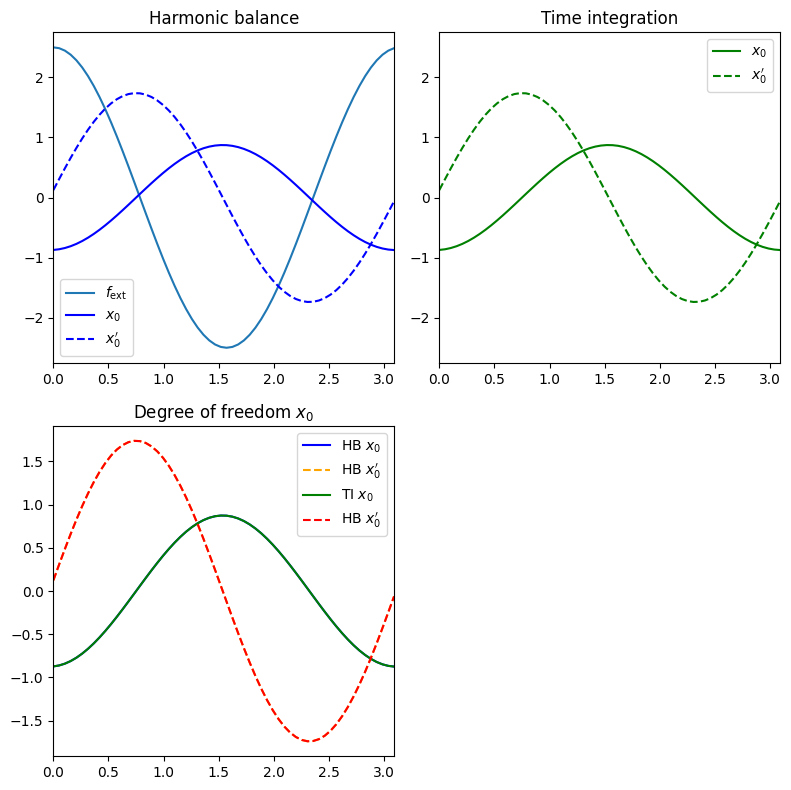

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
colors = ("blue", "orange")
ti_colors = ("green", "red")
[ax.set_xlim(tls[0], tls[-1]) for ax in axs.ravel()]

# External force
ax = axs[0, 0]
ax.plot(
    tls,
    fft.irfft(b_ext.toarray(), norm=freq.FFT_NORM),
    label=r"$f_\text{ext}$",
)

# Harmonic balance
ax = axs[0, 0]
ax.set_title("Harmonic balance")

names = [rf"x_{i}" for i in range(n)]
for xx, xxp, color, name in zip(hb_xx, hb_xxp, colors, names):
    ax.plot(tls, xx, color=color, label=rf"${name}$")
    ax.plot(tls, xxp, color=color, label=rf"${name}'$", ls="--")
ax.legend()

# Time integration
ax = axs[0, 1]
ax.set_title("Time integration")

for xx, xxp, color, name in zip(ti_xx, ti_xxp, ti_colors, names):
    ax.plot(tls, xx, color=color, label=rf"${name}$")
    ax.plot(tls, xxp, color=color, label=rf"${name}'$", ls="--")
ax.legend()
ax.set_ylim(axs[0, 0].get_ylim())

# Compare for each degree of freedom
for i in range(n):
    ax = axs[1, i]
    ax.set_title(rf"Degree of freedom ${names[i]}$")
    ax.plot(tls, hb_xx[i], color=colors[0], label=rf"HB ${names[i]}$")
    ax.plot(
        tls, hb_xxp[i], color=colors[1], label=rf"HB ${names[i]}'$", ls="--"
    )
    ax.plot(tls, ti_xx[i], color=ti_colors[0], label=rf"TI ${names[i]}$")
    ax.plot(
        tls, ti_xxp[i], color=ti_colors[1], label=rf"HB ${names[i]}'$", ls="--"
    )
    ax.legend()

plt.delaxes(axs[-1, -1])
fig.tight_layout()
plt.show()

In [ ]:
print("Relative errors")
print(f"TI: {solve.get_rel_error(ti_R, ti_z)}")
print(f"HB: {solve.get_rel_error(hb_R, hb_z)}")

Relative errors
TI: 3.026623534636019e-07
HB: 7.61113862749299e-13


In [ ]:
s_ = np.s_[:8]

print("Absolute differences in Fourier coefficients")
print(abs(ti_z - hb_z)[s_], "\n")

print("TI coefficients")
print(abs(ti_z)[s_], "\n")

print("HB coefficients")
print(abs(hb_z)[s_])

Absolute differences in Fourier coefficients
[1.29749116e-12 4.57653442e-11 1.28497702e-12 2.68880910e-11
 2.73246562e-12 1.66672494e-11 3.00518707e-12 2.13899332e-11] 

TI coefficients
[1.29756483e-12 4.36464768e-01 1.28483056e-12 5.98711442e-04
 2.73246539e-12 8.67689576e-07 3.00518708e-12 1.25498759e-09] 

HB coefficients
[1.22850939e-14 4.36464768e-01 4.13875028e-16 5.98711455e-04
 1.26780554e-18 8.67703269e-07 2.30679142e-20 1.24103145e-09]


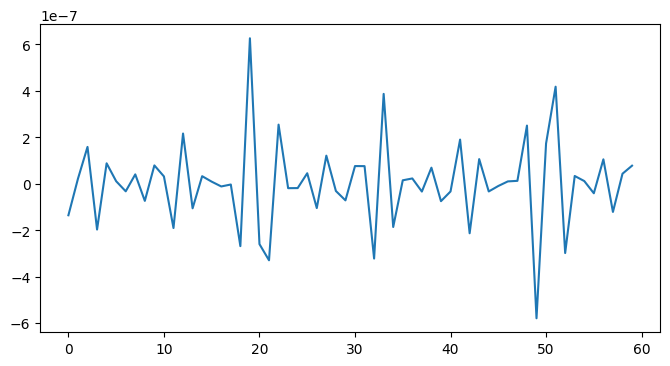

In [ ]:
ti_zpp = freq.get_derivative(omega, ti_z, NH, n, 2)
ti_zzpp = utils.extract_dofs_freq(ti_zpp, n)
ti_xxpp = fft.irfft(ti_zzpp, axis=1, norm=freq.FFT_NORM)

ti_res = utils.get_time_residual(
    ti_xx, ti_xxp, ti_xxpp, M, C, K, f_ext, f_nl, omega, tls, n
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(ti_res[0])

plt.show()

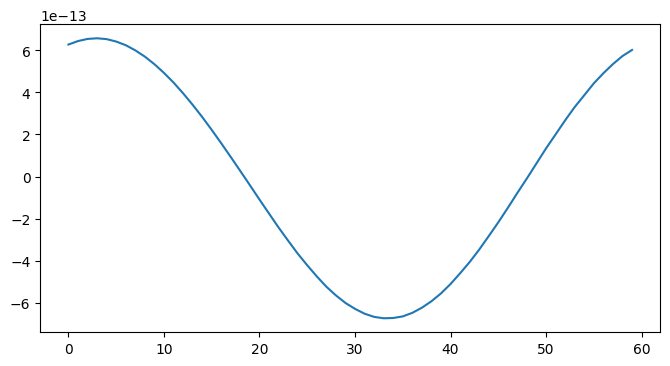

In [ ]:
hb_zpp = freq.get_derivative(omega, hb_zp, NH, n, 1)
hb_zzpp = utils.extract_dofs_freq(hb_zpp, n)
hb_xxpp = fft.irfft(hb_zzpp, axis=1, norm=freq.FFT_NORM)

hb_res = utils.get_time_residual(
    hb_xx, hb_xxp, hb_xxpp, M, C, K, f_ext, f_nl, omega, tls, n
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(hb_res[0])

plt.show()